# Analyzing pitot and Elliott probes from Scanivalve MPS sensor

## Experiment parameters

* Date: 2019-12-03
* Tank: SUSTAIN
* Start time: 17:30 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

**Note: Experiment stopped, last run being 50 Hz.**

In [1]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191203'
data = pd.read_csv(DATAPATH + '/scanivalve_mps_20191203.csv')
time = data['FTime']

fan = range(0, 55, 5)
x = fetch['static_pressure']
run_seconds = 600

start_time = datetime(2019, 12, 3, 17, 30)

In [3]:
data

,Frame,Valve,XTime,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,...,55Press,56Press,57Press,58Press,59Press,60Press,61Press,62Press,63Press,64Press
0,1,Px,0.0,41.00,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.740344,-0.508357,-1.269866,-1.293701,-1.343016,-0.996988,0.127860,-0.508563,-0.291370,-0.450001
1,2,Px,0.0,41.00,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.778152,-0.473837,-1.458085,-1.487674,-1.753976,-1.415345,0.071327,-0.827262,-0.345617,-0.455343
2,3,Px,0.0,40.94,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.375206,-0.606987,-1.099728,-1.282194,-1.539455,-1.283838,0.410549,-0.864659,-0.505480,-0.908632
3,4,Px,0.0,40.94,40.81,41.13,40.75,41.31,40.81,41.25,...,-0.238973,-0.517398,-0.946851,-1.296989,-1.407948,-0.895070,0.402458,-0.886029,-0.613563,-0.804659
4,5,Px,0.0,40.94,40.81,41.13,40.75,41.31,40.81,41.25,...,-0.120206,-0.699864,-1.472880,-1.167126,-1.480277,-0.575344,-0.071353,-0.612946,-0.191507,-0.848632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83995,83996,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,-0.131918,-0.955481,-1.086577,0.617261,-0.416713,-1.432606,0.901491,0.003493,-0.136028,0.002877
83996,83997,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.027945,-1.301920,-1.150687,0.778358,-0.341918,-0.776714,0.998709,0.347261,0.021370,-0.251507
83997,83998,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.152877,-1.200413,-1.223838,0.812878,-0.385480,-0.655070,0.707030,0.298973,-0.355891,-0.092877
83998,83999,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.394316,-1.104249,-1.288770,0.637809,-0.522741,-1.011783,0.758349,-0.066370,-0.542878,0.134384


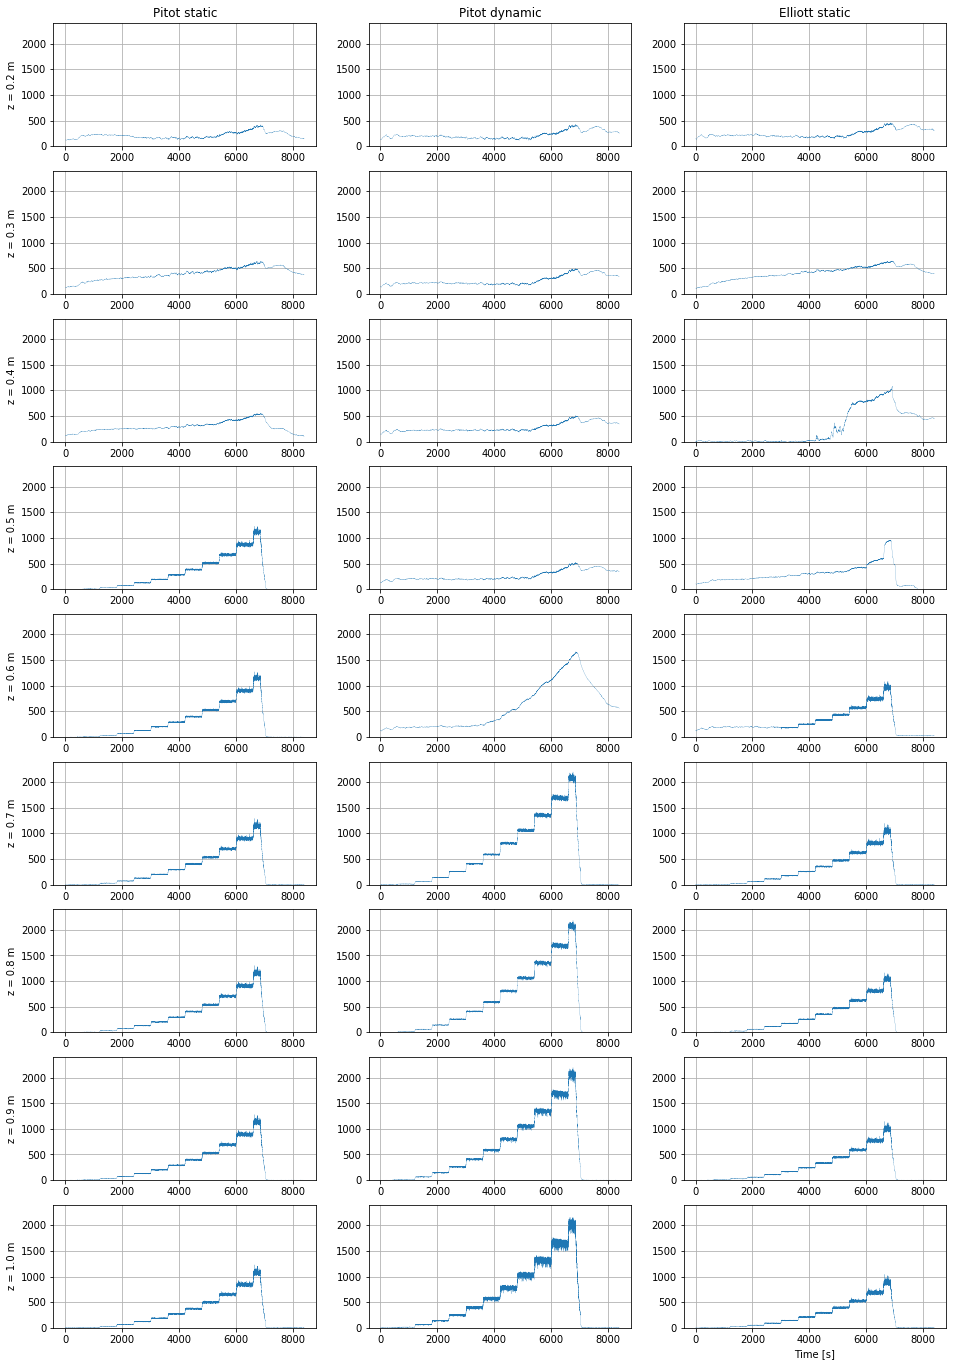

In [4]:
zlow = 1.
dz = 0.1
instrument_name = ['Pitot static', 'Pitot dynamic', 'Elliott static']
fig = plt.figure(figsize=(16, 24))
for k in range(9):
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    for i in range(3):
        ax = plt.subplot2grid((9, 3), (k, i))
        ax.plot(time, data['%2.2i' % pressure_index[i] + 'Press'], lw=0.2)
        plt.ylim(0, 2400)
        plt.grid()
        if k == 0: plt.title(instrument_name[i])
        if i == 0: plt.ylabel('z = %.1f m' % z)
    if k == 8: plt.xlabel('Time [s]')

### Time-average for each fan speed

In [5]:
# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [n * run_seconds + 60 for n in range(len(fan))]
t1 = [(n + 1) * run_seconds for n in range(len(fan))]

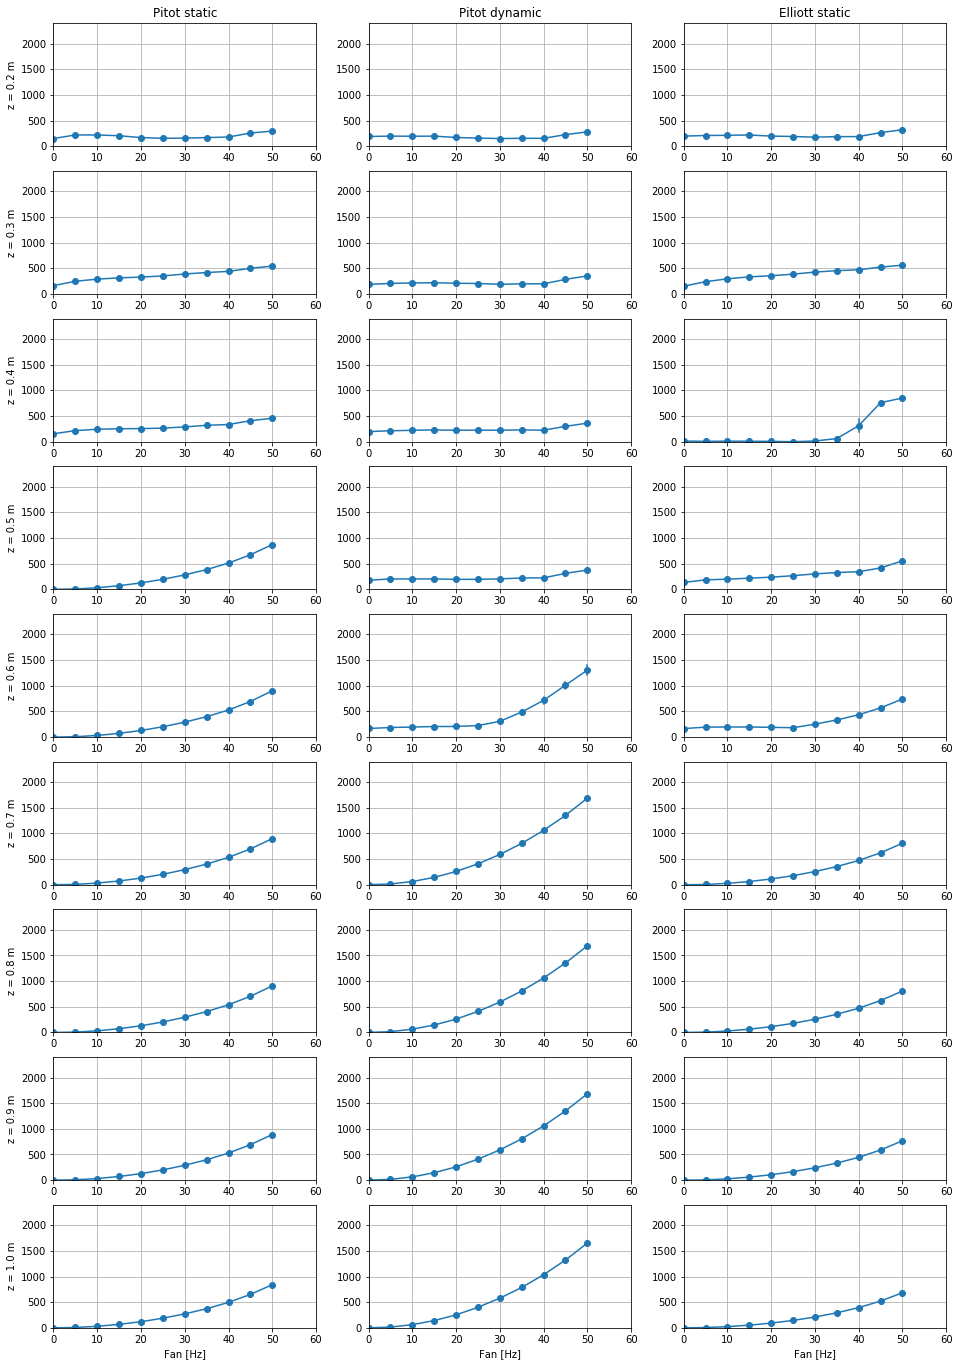

In [6]:
fig = plt.figure(figsize=(16, 24))
for k in range(9):
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    for i in range(3):
        ax = plt.subplot2grid((9, 3), (k, i))
        pmean, pstd = [], []
        for n in range(len(fan)):
            mask = (time >= t0[n]) & (time <= t1[n])
            pres = data['%2.2iPress' % pressure_index[i]][mask]
            pmean.append(np.mean(pres))
            pstd.append(np.std(pres))
        ax.plot(fan, pmean, marker='o')
        for n in range(len(fan)):
            ax.plot([fan[n], fan[n]], [pmean[n] - pstd[n], pmean[n] + pstd[n]], color='tab:blue')
        plt.grid()
        plt.xlim(0, 60)
        plt.ylim(0, 2400)
        if k == 0: plt.title(instrument_name[i])
        if i == 0: plt.ylabel('z = %.1f m' % z)
        if k == 8: plt.xlabel('Fan [Hz]')

In [7]:
pitot_dynamic_mean = np.zeros((9, len(fan)))
pitot_static_mean = np.zeros((9, len(fan)))
for k in range(9):
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    for n in range(len(fan)):
        mask = (time >= t0[n]) & (time <= t1[n])
        pitot_static_mean[k,n] = np.mean(data['%2.2iPress' % pressure_index[0]][mask])
        pitot_dynamic_mean[k,n] = np.mean(data['%2.2iPress' % pressure_index[1]][mask])

In [8]:
def pitot_wind_speed(dp, rho=1.2):
    return (np.sqrt(2 * dp / rho))

In [9]:
pitot_wspd = pitot_wind_speed(np.abs(pitot_dynamic_mean - pitot_static_mean))
heights = np.array([zlow + k * dz - 0.8 for k in range(9)])
heights

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Text(0.5, 1.0, 'Pitot wind speed vs. fan')

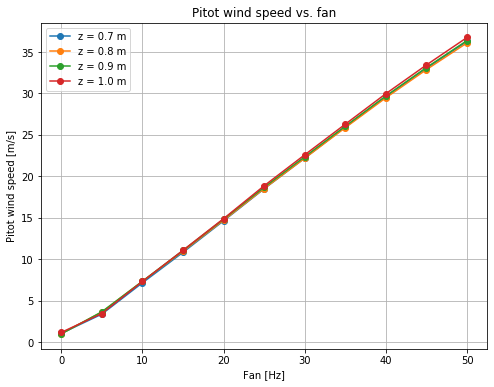

In [10]:
fig = plt.figure(figsize=(8, 6))
for k, height in enumerate(heights):
    if height < 0.69: continue # don't plot bad pitots
    plt.plot(fan, pitot_wspd[k,:], marker='o', label='z = %.1f m' % height)
plt.legend()
plt.grid()
plt.xlabel('Fan [Hz]')
plt.ylabel('Pitot wind speed [m/s]')
plt.title('Pitot wind speed vs. fan')

Text(0.5, 1.0, 'Pitot wind speed vs. height')

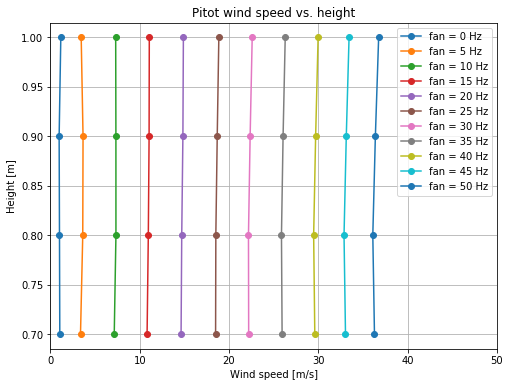

In [11]:
fig = plt.figure(figsize=(8, 6))
for n, f in enumerate(fan):
    good = heights > 0.69
    plt.plot(pitot_wspd[good,n], heights[good], marker='o', label='fan = %i Hz' % f)
plt.xlim(0, 50)
plt.legend()
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Height [m]')
plt.title('Pitot wind speed vs. height')